In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
import plotly.express as px
import sqlite3
import datetime

ABS_PATH = 'C:/Users/Siwoo/PycharmProjects/ValuatorV2'

In [2]:
class Winsorizer:
    def __init__(self):
        self.column_quantiles = []
        self.is_fitted = False

    def fit(self, dataframe, exclude_columns, q=0.99):
        self.column_quantiles = []
        for col in dataframe.columns:
            if col not in exclude_columns:
                if dataframe[col].min() >= 0:
                    lower_bound = -1
                    upper_bound = dataframe[col].quantile(q)
                else:
                    lower_bound = dataframe[col].quantile(1 - q)
                    upper_bound = dataframe[col].quantile(q)
                self.column_quantiles.append((col, lower_bound, upper_bound))
        self.is_fitted = True

    def transform(self, dataframe):
        if self.is_fitted:
            for col, lower, upper in self.column_quantiles:
                dataframe.loc[:, col] = np.clip(dataframe[col], lower, upper)
            return dataframe
        else:
            raise Exception("cannot transform before fitting.")


class FundamentalsDataset:
    def __init__(self):
        with sqlite3.connect(ABS_PATH + '/database/valuator.db') as conn:
            self.df = pd.read_sql("""
            SELECT * FROM bic
            WHERE symbol in
                (SELECT symbol FROM profiles
                WHERE country = "US"
                AND isFund = 0
                AND isEtf = 0
                AND currency = "USD"
                AND (exchangeShortName = "NASDAQ" OR exchangeShortName = "NYSE"))
                AND symbol NOT LIKE '%W'
            ORDER BY symbol, date ASC
            """, con=conn, parse_dates=['fillingDate', 'date'])

            macro_df = pd.read_sql("""
            SELECT * FROM macro_US
            """, con=conn, parse_dates='date')

            cursor = conn.execute("""SELECT * FROM balance""")
            self.balance_columns = [description[0] for description in cursor.description]

            cursor = conn.execute("""SELECT * FROM income""")
            self.income_columns = [description[0] for description in cursor.description]

            cursor = conn.execute("""SELECT * FROM cashflow""")
            self.cashflow_columns = [description[0] for description in cursor.description]

        CPI_base = macro_df[macro_df['date'] == macro_df['date'].max()]['CPI'].values
        macro_df['CPI'] = macro_df['CPI'] / CPI_base

        self.df = self.df.merge(macro_df, how="left", on="date")
        self.df = self.df.set_index(['symbol', 'fillingDate'])
        self.df = self.df.drop(columns=['date', 'reportedCurrency'])

        self.winsorizer = Winsorizer()

    def drop_redundant_features(self):
        balance_ignored_features = ['goodwillAndIntangibleAssets',
                                    'totalLiabilitiesAndStockholdersEquity',
                                    'netDebt',
                                    'cashAndShortTermInvestments']

        income_ignored_features = ['grossProfitRatio',
                                   'costAndExpenses',
                                   'EBITDARatio',
                                   'operatingIncomeRatio',
                                   'incomeBeforeTaxRatio',
                                   'netIncomeRatio',
                                   'EPSDiluted',
                                   'weightedAverageShsOut',
                                   'weightedAverageShsOutDil',
                                   'interestIncome']

        cashflow_ignored_features = []  # nothing yet

        macro_ignored_features = ['realGDP',
                                  "consumerSentiment",
                                  "smoothedUSRecessionProbabilities"]

        if self.CPI_adjusted:
            macro_ignored_features += ['CPI']

        total = balance_ignored_features + income_ignored_features + cashflow_ignored_features + macro_ignored_features
        self.df = self.df.drop(columns=total)
        other_dropped_columns = []
        for column in self.df.columns:
            if "other" in str(column).lower() or "1" in str(column).lower():
                other_dropped_columns.append(column)
        self.df = self.df.drop(columns=other_dropped_columns)

    def adjust_price_w_CPI(self):
        self.CPI_adjusted = True
        self.df['federalFunds'] = self.df['federalFunds'] * self.df['CPI']
        self.df = self.df.divide(self.df['CPI'], axis=0)

    def reorder_columns(self):
        """
        Reorders a DataFrame based on a given list of column names.

        :param df: pandas DataFrame
        :param column_order: List of column names to order the DataFrame by
        :return: Reordered DataFrame
        """
        # Remove duplicates while preserving order
        order = self.balance_columns + self.income_columns + self.cashflow_columns
        seen = set()
        unique_column_order = [col for col in order if col not in seen and not seen.add(col)]

        # Filter out columns that are not in the DataFrame
        valid_columns = [col for col in unique_column_order if col in self.df.columns]

        extra_columns = [col for col in self.df.columns if col not in valid_columns]

        # Reorder the DataFrame
        self.df = self.df[valid_columns + extra_columns]

    def apply_TTM(self):
        self.df = self.df.groupby(level=0).rolling(4, min_periods=4).mean().droplevel(0)

    def apply_asset_constraint(self):
        asset_current_mask = np.abs(
            (self.df['totalCurrentAssets'] + self.df['totalNonCurrentAssets']) / self.df['totalAssets']) < 1.001
        asset_total_mask = np.abs(
            (self.df['totalStockholdersEquity'] + self.df['totalLiabilities']) / self.df['totalAssets']) < 1.001
        mask = np.logical_and(asset_total_mask, asset_current_mask)
        self.df = self.df[mask]

    def apply_nonnegative_constraint(self):
        nonnegative_constraint_columns = []
        for column in self.df.columns:
            if self.df[column].min() < 0 and np.sum(self.df[column] < 0) < 0.01 * len(self.df):
                nonnegative_constraint_columns.append(column)

        for column in nonnegative_constraint_columns:
            self.df = self.df[self.df[column] >= 0]

    def divide_by_total_assets(self):
        self.df = self.df[self.df['totalAssets'] > 0]
        unaffected_cols = ['federalFunds', 'totalAssets']
        affected_cols = [col for col in self.df.columns if col not in unaffected_cols]
        self.df[affected_cols] = self.df[affected_cols].div(self.df['totalAssets'], axis=0)
        self.df['totalAssets'] = np.log(self.df['totalAssets'])

    def dropna(self):
        self.df.dropna(axis=0, how='any')

    def get_train_valid(self, val_split_point, train_valid_gap, winsorize=True, q=0.99):
        train_mask = self.df.index.get_level_values('fillingDate') < (
                val_split_point - datetime.timedelta(days=train_valid_gap))
        valid_mask = self.df.index.get_level_values('fillingDate') > val_split_point
        self.train = self.df.loc[train_mask]
        self.valid = self.df.loc[valid_mask]

        if winsorize:
            self.winsorizer.fit(self.train, exclude_columns=['federalFunds'], q=q)
            self.train = self.winsorizer.transform(self.train)
            self.valid = self.winsorizer.transform(self.valid)

        return self.train, self.valid

In [3]:
df = pd.read_csv('./embeddings_combined.csv')
df = df.set_index(keys='Symbol')

fundamentals = FundamentalsDataset()
fundamentals.reorder_columns()
fundamentals.adjust_price_w_CPI()
fundamentals.drop_redundant_features()
# fundamentals.apply_TTM()
fundamentals.apply_nonnegative_constraint()
fundamentals.dropna()

In [4]:
most_recent = fundamentals.df.reset_index().sort_values(by=['symbol', 'fillingDate']).drop_duplicates(
    subset='symbol', keep='last')
most_recent = most_recent[most_recent['fillingDate'] >= most_recent['fillingDate'].max() - datetime.timedelta(days=120)]
most_recent = most_recent.set_index(keys='symbol')
most_recent['debt_ratio'] = most_recent['totalDebt']/most_recent['totalAssets']
most_recent = most_recent.replace([np.inf, -np.inf], np.nan)
most_recent = most_recent.dropna()

In [5]:
df_combined = pd.merge(df, most_recent, left_index=True, right_index=True, how='inner')
df_combined

,companyName,country,industry,sector,ipoDate,0,1,2,3,4,...,effectOfForexChangesOnCash,netChangeInCash,cashAtEndOfPeriod,cashAtBeginningOfPeriod,operatingCashFlow,capitalExpenditure,freeCashFlow,deferredTaxLiabilitiesNonCurrent,federalFunds,debt_ratio
AA,Alcoa Corporation,US,Aluminum,Basic Materials,2016-11-01,-0.495924,0.571800,0.316517,-0.179828,-0.332709,...,1.007488e+07,-5.440438e+07,9.833087e+08,1.037713e+09,1.994827e+08,-1.894078e+08,1.007488e+07,-2.014977e+07,5.33,0.127914
AAL,American Airlines Group Inc.,US,Airlines,Industrials,2005-09-27,0.113198,0.088197,-0.021743,0.621527,0.933235,...,-4.553848e+08,-4.614297e+08,1.499143e+09,1.960573e+09,-1.361117e+09,-8.493128e+08,-2.210430e+09,5.823283e+08,5.33,0.644851
AAME,Atlantic American Corporation,US,Insurance—Life,Financial Services,1980-03-17,0.013044,-0.205205,0.295235,0.273281,-0.165229,...,0.000000e+00,-3.299953e+05,2.421417e+07,2.454416e+07,1.369582e+06,-7.085789e+03,1.362496e+06,0.000000e+00,5.33,0.101645
AAN,"The Aaron's Company, Inc.",US,Rental & Leasing Services,Industrials,2020-11-25,-0.279872,-0.025932,-0.252483,0.125335,-0.051193,...,4.130703e+04,1.986969e+07,5.947708e+07,3.960739e+07,3.154245e+07,-2.567887e+07,5.863583e+06,8.384017e+07,5.33,0.381399
AAOI,"Applied Optoelectronics, Inc.",US,Semiconductors,Technology,2013-09-26,-0.846714,-0.102832,-0.385337,0.635604,-0.799572,...,6.115455e+05,2.403464e+07,5.550959e+07,3.147495e+07,1.561607e+06,-9.678942e+06,-8.117334e+06,0.000000e+00,5.33,0.311093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTS,Zoetis Inc.,US,Drug Manufacturers—Specialty & Generic,Healthcare,2013-02-01,-0.356731,0.199602,0.424037,0.021630,-0.183587,...,-3.022465e+06,2.891492e+08,2.056284e+09,1.767135e+09,9.037171e+08,-1.994827e+08,7.042344e+08,1.470933e+08,5.33,0.476200
ZUMZ,Zumiez Inc.,US,Apparel Retail,Consumer Cyclical,2005-05-06,0.007407,0.088800,0.239730,0.473745,-0.145856,...,-1.842872e+06,-9.088941e+06,5.483102e+07,6.391996e+07,1.359397e+06,-4.380615e+06,-3.021218e+06,0.000000e+00,5.33,0.330159
ZUO,"Zuora, Inc.",US,Software—Infrastructure,Technology,2018-04-12,0.202764,0.190754,-0.013427,-0.258780,0.506896,...,7.141431e+05,-1.594688e+08,2.571970e+08,4.166658e+08,3.017782e+07,-3.087589e+06,2.709023e+07,3.741467e+06,5.33,0.489642
ZVIA,Zevia PBC,US,Beverages—Non-Alcoholic,Consumer Defensive,2021-07-22,-0.976855,0.438143,0.462896,0.133678,-0.032204,...,0.000000e+00,-6.636326e+06,3.219429e+07,3.883062e+07,-6.655469e+06,-6.750173e+04,-6.722970e+06,0.000000e+00,5.33,0.021440


In [6]:
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

train, test = train_test_split(df_combined, test_size=0.2, shuffle=True, random_state=42)

In [7]:
def test_model(train_x, train_y, test_x, test_y, model, label_name, logged=False):
    model.fit(train_x, train_y)
    pred_y = model.predict(test_x)
    if logged:
        pred_y = np.exp(pred_y) - 1
        test_y = np.exp(test_y) - 1
    r, p = pearsonr(test_y, pred_y)
    plt.scatter(pred_y, test_y)
    plt.xlabel("prediction")
    plt.ylabel("ground truth")
    plt.title(f"regression on {label_name}")
    print(f"R: {r}, p-value: {p}")

In [8]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

embedding_cols = [str(i) for i in range(1024)]
y_label_name = ['freeCashFlow']
is_loggable = False

train_x, train_y = train[embedding_cols], train[y_label_name]
test_x, test_y = test[embedding_cols], test[y_label_name]

if is_loggable:
    train_y = np.log(train_y + 1)
    test_y = np.log(test_y + 1)

scaler = StandardScaler()
pca = PCA(n_components=512)

train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

train_x = pca.fit_transform(train_x)
test_x = pca.transform(test_x)

# fundamentals.winsorizer.fit(train_y, exclude_columns=[])
# train_y = fundamentals.winsorizer.transform(train_y).values.squeeze()
# test_y = fundamentals.winsorizer.transform(test_y).values.squeeze()

quantile_transformer = QuantileTransformer()
train_y = quantile_transformer.fit_transform(train_y).squeeze()
test_y = quantile_transformer.transform(test_y).squeeze()

In [9]:
model_KNN = KNeighborsRegressor(n_neighbors=12)
model_linear = LinearRegression(fit_intercept=False)
model_lasso = Lasso(fit_intercept=True, max_iter=10000)
model_XGB = XGBRegressor()
model_SVR = SVR(kernel='rbf')

R: 0.4515835729747424, p-value: 2.216050347847453e-33


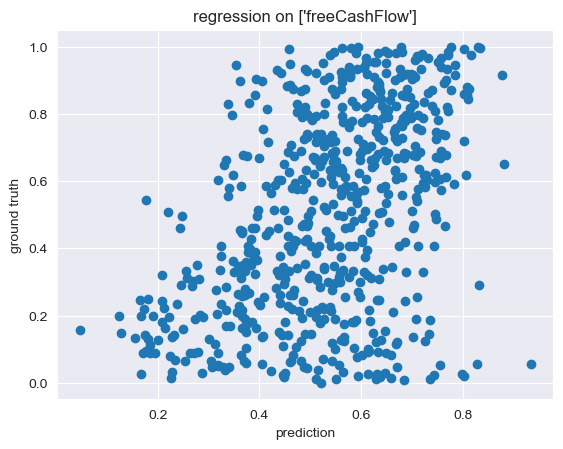

In [10]:
test_model(train_x, train_y, test_x, test_y, model_KNN, y_label_name)

R: 0.4709701492757705, p-value: 1.5467319720672584e-36


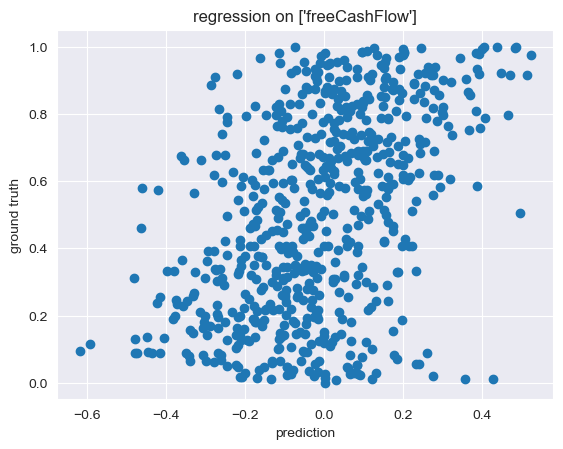

In [11]:
test_model(train_x, train_y, test_x, test_y, model_linear, y_label_name)

R: nan, p-value: nan


C:\Users\Siwoo\miniconda3\envs\MLenv\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


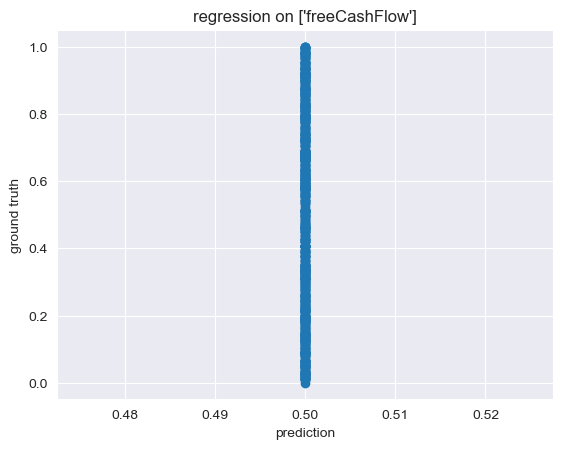

In [12]:
test_model(train_x, train_y, test_x, test_y, model_lasso, y_label_name)

R: 0.5386368459881594, p-value: 2.767121230862064e-49


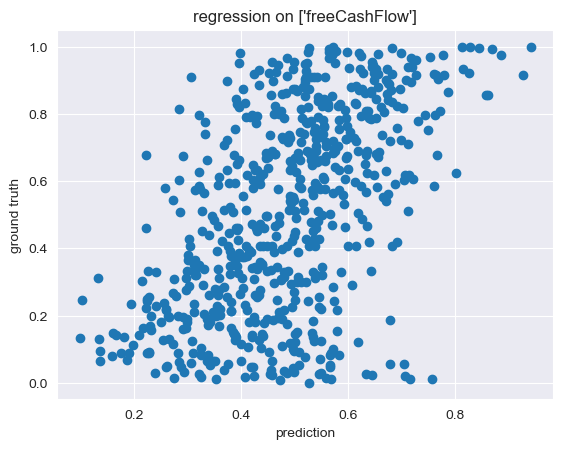

In [13]:
test_model(train_x, train_y, test_x, test_y, model_SVR, y_label_name)

R: 0.3925755823959878, p-value: 6.12862650079275e-25


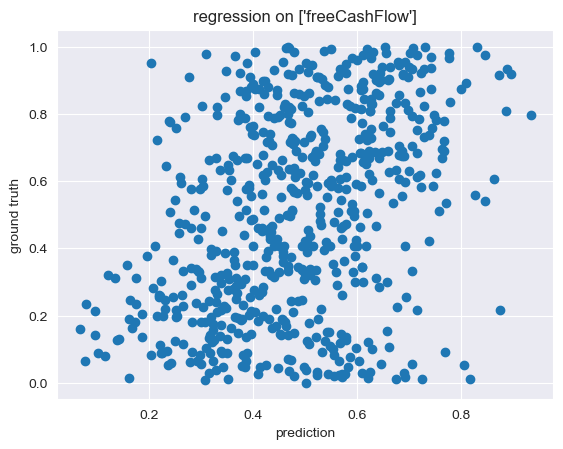

In [14]:
test_model(train_x, train_y, test_x, test_y, model_XGB, y_label_name)

In [15]:
evectors = pca.components_  # (component, eigenvector)
var_ratio = pca.explained_variance_ratio_

def vector_search(db: np.ndarray, query: np.ndarray):
    # Calculate the dot product between db and query vectors
    dot_product = np.dot(query, db.T)

    # Compute the norm of each vector in the database
    db_norm = np.linalg.norm(db, axis=1)

    # Compute the norm of each query vector
    query_norm = np.linalg.norm(query, axis=1)

    # To avoid division by zero, add a small constant in the norm calculation
    db_norm[db_norm == 0] = 1e-10
    query_norm[query_norm == 0] = 1e-10

    # Calculate the cosine similarity by normalizing the dot product with the norms
    cosine_similarity = dot_product / np.outer(query_norm, db_norm)

    return cosine_similarity

In [16]:
search_result = vector_search(scaler.transform(df[embedding_cols].values), evectors)
# negative so that we can make it descending
# find the top three
ranked_values = -np.sort(-search_result, axis=1)[:, :5]
ranked_indices = np.argsort(-search_result, axis=1)[:, :5]
eigencompanies = []

for i, (indices, values) in enumerate(zip(ranked_indices, var_ratio)):
    top_companies = df.iloc[indices]
    top_companies = top_companies[['companyName', 'sector', 'industry']]

    # Calculating majority vote and agreement for 'sector'
    most_common_sector = top_companies['sector'].mode()[0]
    sector_agreement = (top_companies['sector'] == most_common_sector).mean()

    # Calculating majority vote and agreement for 'industry'
    most_common_industry = top_companies['industry'].mode()[0]
    industry_agreement = (top_companies['industry'] == most_common_industry).mean()

    subset = {
        "PCA": i + 1,
        "variance_explained": values,
        "names": top_companies['companyName'].to_list(),
        "sector": most_common_sector,
        "sector_agreement": sector_agreement,
        "industry": most_common_industry,
        "industry_agreement": industry_agreement
    }
    eigencompanies.append(subset)

# Concatenate all results into a single DataFrame
eigencompanies = pd.DataFrame.from_dict(eigencompanies)
eigencompanies = eigencompanies[['PCA', 'variance_explained', 'names', 'sector', 'industry']]

C:\Users\Siwoo\miniconda3\envs\MLenv\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [17]:
coefficients = model_linear.coef_
coefficients

array([-8.95308915e-03,  8.59788526e-03,  4.31073391e-03, -8.14488750e-03,
        1.02171431e-03, -9.07422265e-03,  5.51566667e-04, -1.38032023e-02,
       -4.16939979e-03, -1.06775915e-02, -1.58532016e-04,  1.65038493e-03,
       -6.07865513e-03,  1.25274660e-02,  1.69011149e-03, -2.65677054e-03,
        3.07811021e-03, -2.46031102e-03,  1.75641011e-03, -3.70476374e-03,
        5.10899725e-03, -3.52536561e-03, -1.81809526e-03, -6.26188059e-03,
        1.26644209e-03, -2.39203994e-03,  6.44410656e-03,  4.18010525e-03,
       -1.54226460e-03,  1.71413544e-03, -6.15547444e-04,  4.13793786e-03,
       -8.59524655e-03,  3.06253153e-03,  5.54988670e-04, -4.11049000e-03,
       -6.05552058e-03, -2.28384953e-03,  9.40988002e-04,  4.04511906e-03,
       -2.16101657e-03, -5.80921504e-03,  1.54569011e-03, -6.93112861e-03,
        1.33196185e-03, -5.53427931e-03, -8.57173275e-03, -2.43670488e-03,
       -3.85994739e-03,  1.30597087e-04, -9.92098263e-04,  2.74941382e-03,
        2.20329721e-04,  

In [18]:
sorted_idx = np.abs(coefficients).argsort()[::-1]

In [19]:
coef_sorted = pd.Series(coefficients[sorted_idx], name='LR coefficients')
eigencompanies_sorted = eigencompanies.iloc[sorted_idx].reset_index(drop=True)

pd.concat([eigencompanies_sorted, coef_sorted], axis=1)

,PCA,variance_explained,names,sector,industry,LR coefficients
0,502,0.000115,"[MySale Group plc, Spectra7 Microsystems Inc.,...",Basic Materials,Gold,-0.043882
1,453,0.000176,"[Cartel Blue, Inc., Kingsmen Creatives Ltd., S...",Consumer Cyclical,Apparel Manufacturing,0.032620
2,500,0.000117,"[Vocento, S.A., Italia Independent Group S.p.A...",Financial Services,Biotechnology,-0.032328
3,457,0.000169,"[Touchwood Entertainment Limited, iSign Soluti...",Communication Services,Advertising Agencies,-0.032157
4,481,0.000139,"[Interups, Inc., Sangam (India) Limited, Simpl...",Technology,Drug Manufacturers—Specialty & Generic,-0.029260
...,...,...,...,...,...,...
507,200,0.001176,"[Lecron Industrial Development Group Co., Ltd....",Real Estate,Chemicals,0.000070
508,76,0.003438,"[KARO INVEST a.s., National Research Corporati...",Consumer Cyclical,Farm & Heavy Construction Machinery,-0.000065
509,181,0.001356,"[Takamatsu Construction Group Co., Ltd., Shuan...",Industrials,Capital Goods,0.000051
510,273,0.000706,"[LARK Distilling Co. Ltd., Verus International...",Consumer Defensive,Beverages—Wineries & Distilleries,-0.000037


In [20]:
pred = model_linear.predict(test_x)
ranked_indices = np.argsort(-pred)[:10]

In [21]:
test_top10 = test.iloc[ranked_indices]
test_top10[['companyName', 'country', 'industry', 'sector', 'freeCashFlow']]

,companyName,country,industry,sector,freeCashFlow
ADBE,Adobe Inc.,US,Software—Infrastructure,Technology,1.561607e+09
RPM,RPM International Inc.,US,Specialty Chemicals,Basic Materials,3.751261e+08
CET,Central Securities Corp.,US,Asset Management,Financial Services,5.772016e+06
BRK-B,Berkshire Hathaway Inc.,US,Insurance—Diversified,Financial Services,8.757090e+09
MET,"MetLife, Inc.",US,Insurance—Life,Financial Services,4.834937e+09
NDAQ,"Nasdaq, Inc.",US,Financial Data & Stock Exchanges,Financial Services,3.778082e+08
DNB,"Dun & Bradstreet Holdings, Inc.",US,Financial Data & Stock Exchanges,Financial Services,9.974136e+07
MCO,Moody's Corporation,US,Financial Data & Stock Exchanges,Financial Services,4.070253e+08
WFC,Wells Fargo & Company,US,Banks—Diversified,Financial Services,1.833830e+10
ALB,Albemarle Corporation,US,Specialty Chemicals,Basic Materials,-7.881653e+08


In [22]:
pred = model_KNN.predict(test_x)
ranked_indices = np.argsort(-pred)[:10]
test_top10 = test.iloc[ranked_indices]
test_top10[['companyName', 'country', 'industry', 'sector', 'freeCashFlow']]

,companyName,country,industry,sector,freeCashFlow
HES,Hess Corporation,US,Oil & Gas E&P,Energy,-1.007488e+08
JJSF,J&J Snack Foods Corp.,US,Packaged Foods,Consumer Defensive,2.924034e+07
RPM,RPM International Inc.,US,Specialty Chemicals,Basic Materials,3.751261e+08
MET,"MetLife, Inc.",US,Insurance—Life,Financial Services,4.834937e+09
BRID,Bridgford Foods Corporation,US,Packaged Foods,Consumer Defensive,-2.574330e+06
BRK-B,Berkshire Hathaway Inc.,US,Insurance—Diversified,Financial Services,8.757090e+09
CRK,"Comstock Resources, Inc.",US,Oil & Gas E&P,Energy,-1.087543e+08
AIG-PA,"American International Group, Inc.",US,Insurance—Diversified,Financial Services,1.328877e+09
LDOS,"Leidos Holdings, Inc.",US,Information Technology Services,Technology,2.276924e+08
AM,Antero Midstream Corporation,US,Oil & Gas Midstream,Energy,1.555028e+08


In [25]:
pred = model_SVR.predict(test_x)
ranked_indices = np.argsort(-pred)[:10]
test_top10 = test.iloc[ranked_indices]
test_top10[['companyName', 'country', 'industry', 'sector', 'freeCashFlow']]

,companyName,country,industry,sector,freeCashFlow
BRK-B,Berkshire Hathaway Inc.,US,Insurance—Diversified,Financial Services,8.757090e+09
RPM,RPM International Inc.,US,Specialty Chemicals,Basic Materials,3.751261e+08
ADBE,Adobe Inc.,US,Software—Infrastructure,Technology,1.561607e+09
MA,Mastercard Incorporated,US,Credit Services,Financial Services,4.083351e+09
NWL,Newell Brands Inc.,US,Household & Personal Products,Consumer Defensive,1.773180e+08
LII,Lennox International Inc.,US,Building Products & Equipment,Industrials,1.793329e+08
MET,"MetLife, Inc.",US,Insurance—Life,Financial Services,4.834937e+09
AMZN,"Amazon.com, Inc.",US,Internet Retail,Consumer Cyclical,2.808576e+10
MCO,Moody's Corporation,US,Financial Data & Stock Exchanges,Financial Services,4.070253e+08
HSY,The Hershey Company,US,Confectioners,Consumer Defensive,5.391474e+08
